# TsSHAP con Sliding window

In [1]:
import shap
import numpy as np
import pandas as pd
from fastcore.foundation import L
from dvats.load import TSArtifact, infer_or_inject_freq
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from fastai.tabular.all import * 
from tsai.all import *

In [2]:
print_flag = True
reset_kernel = False

## Obtain the dataset

In [3]:
! wget "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv"

--2024-01-17 16:47:57--  https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86845 (85K) [text/plain]
Saving to: ‘example_wp_log_peyton_manning.csv’

example_wp_log_peyt 100%[===================>]  84.81K  --.-KB/s    in 0.005s  

2024-01-17 16:47:57 (16.5 MB/s) - ‘example_wp_log_peyton_manning.csv’ saved [86845/86845]



In [4]:
df_peyton = pd.read_csv("example_wp_log_peyton_manning.csv")

In [5]:
! rm "example_wp_log_peyton_manning.csv"

In [6]:
peyton_time_col = 0
peyton_date_offset = 0

In [7]:
index = pd.DatetimeIndex(df_peyton.iloc[:, peyton_time_col])
index

DatetimeIndex(['2007-12-10', '2007-12-11', '2007-12-12', '2007-12-13',
               '2007-12-14', '2007-12-15', '2007-12-16', '2007-12-17',
               '2007-12-18', '2007-12-19',
               ...
               '2016-01-11', '2016-01-12', '2016-01-13', '2016-01-14',
               '2016-01-15', '2016-01-16', '2016-01-17', '2016-01-18',
               '2016-01-19', '2016-01-20'],
              dtype='datetime64[ns]', name='ds', length=2905, freq=None)

In [8]:
# Add offset
offset_timedelta = pd.to_timedelta(peyton_date_offset, unit='D')
index += offset_timedelta

In [9]:
# Delete time column
col_name = df_peyton.columns[peyton_time_col]
df_peyton = df_peyton.drop(col_name, axis=1)
df_peyton.head

<bound method NDFrame.head of               y
0      9.590761
1      8.519590
2      8.183677
3      8.072467
4      7.893572
...         ...
2900   7.817223
2901   9.273878
2902  10.333775
2903   9.125871
2904   8.891374

[2905 rows x 1 columns]>

In [10]:
df_train = infer_or_inject_freq(
    df_peyton, 
    injected_freq= '1d', 
    start_date = '2007-12-10', 
    format = '%Y-%m-%d %H:%M:%S'
)
print(df_train.index.freq)

<Day>


## Backtested historical forecasts

In [11]:
window_length = 30
horizon = 15
X_train, _ = prepare_forecasting_data(df_train, fcst_history = window_length, fcst_horizon =1)
if print_flag:
    print("X ~", X_train.shape)

X ~ (2875, 1, 30)


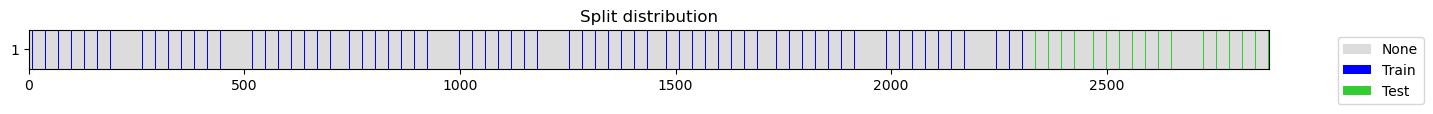

In [12]:
splits = get_forecasting_splits(
        df = df_train, 
        fcst_history = window_length,
        fcst_horizon = 1,
        stride = horizon,
        test_size = 0.2,
        show_plot = True
    )

## Interpretable features

In [13]:
def lagged_val(df, t, lagged_id): return  df.iloc[lagged_id].values[0]

In [14]:
def lag_features(df, t, lags=3):
    """Value at previous time steps"""
    lagged_id = t-lags
    val = lagged_val (df, t, lagged_id)
    print("t ", t, " lagged ", lagged_id, " val ", val)
    return val

In [15]:
lag_features(df_peyton, 10)

t  10  lagged  7  val  8.82922635473185


8.82922635473185

In [16]:
def seasonal_lag_features(df, t, lags = 2, m = 365):
    """Vakue at time steps for the previous seasons"""
    lagged_id = t - (lags*m)
    val = lagged_val (df, t, lagged_id)
    print("t ", t, " lagged ", lagged_id, " val ", val)
    return val

In [17]:
seasonal_lag_features(df_peyton, 1000)

t  1000  lagged  270  val  7.44949800538285


7.44949800538285

In [32]:
def rolling_windows_features(df, t, window = 3, print_flag = print_flag):
    """Rolling window statistics (mean, max, min). The max of the past 3 values"""
    val_1 = lagged_val(df, t, 1)
    val_2 = lagged_val(df, t, 2)
    val_3 = lagged_val(df, t, 3)
    mean_ = (val_1 + val_2 + val_3)/3
    max_ = max(val_1, val_2, val_3)
    min_ = min(val_1, val_2, val_3)
    if print_flag: print(val_1, val_2, val_3, mean_, max_, min_)
    return mean_, max_, min_

In [33]:
rolling_windows_features(df_peyton, 10)

8.51959031601596 8.18367658262066 8.07246736935477 8.258578089330463 8.51959031601596 8.07246736935477


(8.258578089330463, 8.51959031601596, 8.07246736935477)

In [ ]:
for train_id in splits[0]:
    if np.max(train_id) >= X_train.shape[0]:
        print("Any train id exceedes de limits.")

for test_id in splits[1]:
    if np.max(test_id) >= X_train.shape[0]:
        print("Any test id exceedes de limits.")

In [ ]:
cbs = L()
tfms = [ToFloat(), None]
batch_tfms = [TSStandardize(by_sample=False, use_single_batch=False)]

In [ ]:
dls = get_ts_dls(X_train, splits=splits, tfms=tfms, bs=64, batch_tfms=batch_tfms)

In [ ]:
learn = ts_learner(dls, InceptionTimePlus, metrics=[rmse], y_range=[X_train.min(), X_train.max()])
learn.fit_one_cycle(10)

In [ ]:
learn.validate()

In [ ]:
rmse_score = learn.validate()[1].item()
rmse_scores.append(rmse_score)

In [ ]:
print("Execution ended")
beep(1)
if reset_kernel:
    import os
    os._exit(00)